In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/custom.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))

# Chapter 3 — Exploratory Data Analysis (EDA)
## Lesson 8: Multicollinearity and Confounding Signals (Detection and Mitigation)

This lesson targets two issues that frequently break interpretability and produce misleading EDA narratives:

- **Multicollinearity**: predictors share overlapping information, creating unstable parameter estimates.
- **Confounding signals**: an apparent relationship is partially or fully driven by a third variable.

You will detect both problems and apply mitigation patterns using multiple datasets from the repository.


## 1) Multicollinearity in formulas and geometry

For linear regression,

$$
y = X\beta + \varepsilon, \qquad \varepsilon \sim (0, \sigma^2 I)
$$

the OLS estimator is

$$
\hat\beta = (X^T X)^{-1} X^T y
$$

and

$$
\mathrm{Var}(\hat\beta) = \sigma^2 (X^T X)^{-1}.
$$

When predictors are highly correlated, $X^T X$ becomes ill-conditioned; its inverse magnifies noise. In SVD terms, small singular values correspond to nearly redundant directions in feature space, and OLS becomes numerically fragile in those directions.


## 2) Confounding: why aggregated EDA can be wrong

Confounding is a structural pattern: a variable $Z$ influences both an exposure $T$ and an outcome $Y$, creating a misleading association between $T$ and $Y$. A common symptom is Simpson’s paradox—trends in aggregated data differ from within-group trends.

In ML, confounding can create high performance while harming robustness, interpretability, and fairness (proxy effects).


## 3) Mitigation overview

Choose mitigation based on your goal:

- If **interpretation** matters: reduce redundancy, keep one representative feature, center engineered terms, and report stability.
- If **prediction** matters: regularization (Ridge/Elastic Net) and robust validation are often enough; PCA may help when you can trade interpretability for stability.

In the next sections, you will apply diagnostics ($VIF$, condition number, bootstrap stability) and mitigation (Ridge/PCA) on real datasets.


## 4) Datasets used

- Regression: `../../../Datasets/Regression/house-prices.csv`
- Regression: `../../../Datasets/Regression/diamonds.csv`
- Classification: `../../../Datasets/Classification/diabetes.csv`


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score

import statsmodels.api as sm

np.set_printoptions(suppress=True, precision=4)
pd.set_option("display.max_columns", 200)


In [3]:
def build_design_matrix(X: pd.DataFrame):
    """Return (X_mat, feature_names) with numeric passthrough + one-hot categoricals (drop first)."""
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = [c for c in X.columns if c not in num_cols]

    pre = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    X_mat = pre.fit_transform(X)
    feature_names = pre.get_feature_names_out().tolist()
    return X_mat, feature_names

def compute_vif(X_mat: np.ndarray, feature_names):
    """Compute VIF for each column in X_mat."""
    vifs = []
    for j in range(X_mat.shape[1]):
        y_j = X_mat[:, j]
        X_others = np.delete(X_mat, j, axis=1)
        X_others = sm.add_constant(X_others)
        model = sm.OLS(y_j, X_others).fit()
        r2 = model.rsquared
        vifs.append(1.0 / (1.0 - r2 + 1e-12))
    out = pd.DataFrame({"feature": feature_names, "VIF": vifs}).sort_values("VIF", ascending=False)
    return out.reset_index(drop=True)

def condition_number(X_mat: np.ndarray):
    """Condition number based on SVD."""
    _, s, _ = np.linalg.svd(X_mat, full_matrices=False)
    return float(s.max() / s.min()) if s.min() > 0 else float("inf")

def corr_pairs(df_num: pd.DataFrame, top_k=12):
    c = df_num.corr().abs()
    c = c.where(~np.eye(len(c), dtype=bool))
    return c.stack().sort_values(ascending=False).head(top_k)

def bootstrap_coefs_linear(X: np.ndarray, y: np.ndarray, B=400, alpha_ridge=10.0, seed=42):
    rng = np.random.default_rng(seed)
    ols_coefs = []
    ridge_coefs = []
    for _ in range(B):
        idx = rng.integers(0, len(y), size=len(y))
        Xb, yb = X[idx], y[idx]

        # OLS with intercept
        Xc = sm.add_constant(Xb)
        m = sm.OLS(yb, Xc).fit()
        ols_coefs.append(m.params)

        # Ridge on standardized predictors
        sc = StandardScaler()
        Xs = sc.fit_transform(Xb)
        r = Ridge(alpha=alpha_ridge)
        r.fit(Xs, yb)
        ridge_coefs.append(np.concatenate([[r.intercept_], r.coef_]))

    return np.vstack(ols_coefs), np.vstack(ridge_coefs)

def partial_corr_from_precision(X_std: np.ndarray, feature_names):
    """Estimate partial correlations via precision matrix (inverse covariance)."""
    S = np.cov(X_std, rowvar=False)
    P = np.linalg.pinv(S)
    d = np.sqrt(np.diag(P))
    pc = -P / (d[:, None] * d[None, :] + 1e-12)
    np.fill_diagonal(pc, 1.0)
    return pd.DataFrame(pc, index=feature_names, columns=feature_names)


## 5) Dataset A — House prices: multicollinearity diagnostics

In [4]:
house_path = "../../../Datasets/Regression/house-prices.csv"
house = pd.read_csv(house_path)
house.head()

,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [5]:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Home          128 non-null    int64 
 1   Price         128 non-null    int64 
 2   SqFt          128 non-null    int64 
 3   Bedrooms      128 non-null    int64 
 4   Bathrooms     128 non-null    int64 
 5   Offers        128 non-null    int64 
 6   Brick         128 non-null    object
 7   Neighborhood  128 non-null    object
dtypes: int64(6), object(2)
memory usage: 8.1+ KB


In [6]:
df = house.copy()

y = df["Price"].astype(float)
df["Brick"] = df["Brick"].map({"Yes": 1, "No": 0})
X = df.drop(columns=["Price"])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

num_cols, cat_cols

(['Home', 'SqFt', 'Bedrooms', 'Bathrooms', 'Offers', 'Brick'],
 ['Neighborhood'])

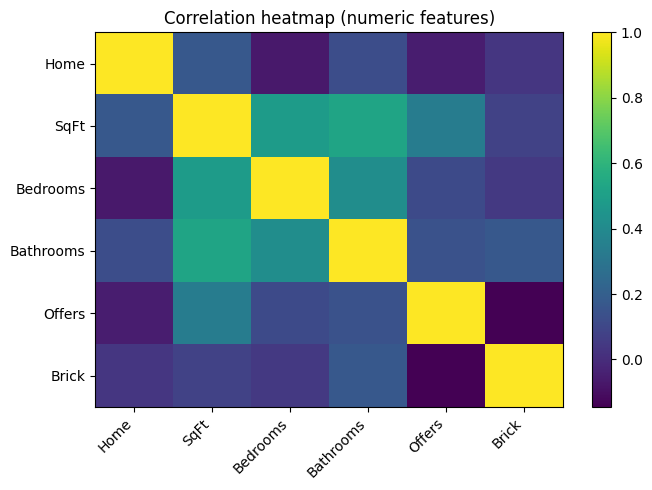

SqFt       Bathrooms    0.522745
Bathrooms  SqFt         0.522745
Bedrooms   SqFt         0.483807
SqFt       Bedrooms     0.483807
Bathrooms  Bedrooms     0.414556
Bedrooms   Bathrooms    0.414556
SqFt       Offers       0.336923
Offers     SqFt         0.336923
Bathrooms  Brick        0.171977
Brick      Bathrooms    0.171977
SqFt       Home         0.168553
Home       SqFt         0.168553
dtype: float64

In [7]:
corr = X[num_cols].corr()

plt.figure(figsize=(7, 5))
plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()

corr_pairs(X[num_cols], top_k=12)

### VIF on the design matrix (numeric + one-hot categoricals)

In [8]:
X_mat, feat = build_design_matrix(X)
vif = compute_vif(X_mat, feat)
vif.head(25)

,feature,VIF
0,SqFt,1.975506
1,Offers,1.750585
2,Bedrooms,1.742065
3,Neighborhood_West,1.732270
4,Neighborhood_North,1.692545
5,Bathrooms,1.514766
6,Home,1.114580
7,Brick,1.104268


### Conditioning diagnostics (standardized numeric matrix)

In [9]:
X_num = X[num_cols].astype(float).values
X_std = StandardScaler().fit_transform(X_num)
kappa = condition_number(X_std)

XtX = X_std.T @ X_std
eigvals = np.linalg.eigvalsh(XtX)

kappa, pd.Series(eigvals).sort_values().head(10)

(2.334153408923319,
 0     49.143744
 1     67.020337
 2    101.306667
 3    130.447741
 4    152.333018
 5    267.748493
 dtype: float64)

### Partial correlations (direct associations after controlling for others)

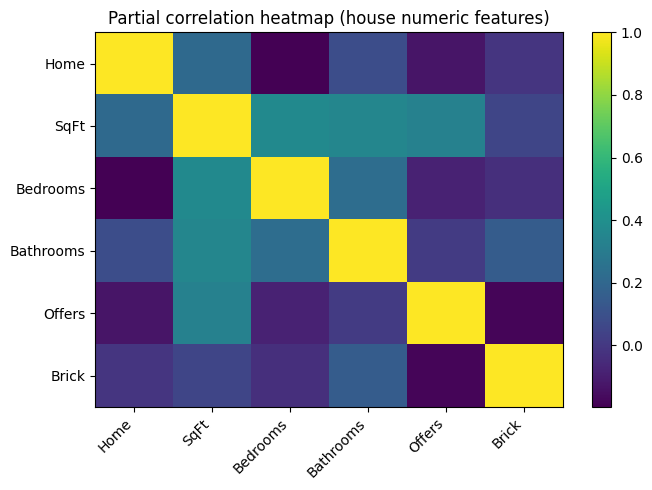

Bedrooms   SqFt         0.371326
SqFt       Bedrooms     0.371326
Bathrooms  SqFt         0.351894
SqFt       Bathrooms    0.351894
           Offers       0.330694
Offers     SqFt         0.330694
Bathrooms  Bedrooms     0.229408
Bedrooms   Bathrooms    0.229408
SqFt       Home         0.210558
Home       SqFt         0.210558
dtype: float64

In [10]:
# Partial correlation on house numeric features (after standardization)
X_num = X[num_cols].astype(float).values
X_std = StandardScaler().fit_transform(X_num)

pc = partial_corr_from_precision(X_std, num_cols)

plt.figure(figsize=(7, 5))
plt.imshow(pc.values, aspect="auto")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Partial correlation heatmap (house numeric features)")
plt.tight_layout()
plt.show()

# show strongest partial correlations (excluding diagonal)
pc_abs = pc.abs()
np.fill_diagonal(pc_abs.values, 0.0)
pairs = pc_abs.stack().sort_values(ascending=False)
pairs.head(10)

### OLS coefficients and fragility

In [11]:
X_ols = sm.add_constant(X[num_cols].astype(float))
ols = sm.OLS(y, X_ols).fit()
ols.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-1.585e+04,1.09e+04,-1.457,0.148,-3.74e+04,5683.478
Home,-10.6563,31.978,-0.333,0.740,-73.965,52.652
SqFt,59.7119,7.233,8.255,0.000,45.392,74.032
Bedrooms,9640.2640,1873.668,5.145,0.000,5930.844,1.33e+04
Bathrooms,9900.9404,2698.310,3.669,0.000,4558.924,1.52e+04
Offers,-1.222e+04,1160.636,-10.527,0.000,-1.45e+04,-9920.782
Brick,1.714e+04,2491.092,6.880,0.000,1.22e+04,2.21e+04


### Bootstrap stability: OLS vs Ridge

In [12]:
Xn = X[num_cols].astype(float).values
yn = y.values.astype(float)

ols_coefs, ridge_coefs = bootstrap_coefs_linear(Xn, yn, B=400, alpha_ridge=10.0, seed=42)

coef_names = ["const"] + num_cols
ols_std = pd.Series(ols_coefs.std(axis=0), index=coef_names).sort_values(ascending=False)
ridge_std = pd.Series(ridge_coefs.std(axis=0), index=["intercept"] + num_cols).sort_values(ascending=False)

ols_std.head(10), ridge_std.head(10)

(const        11168.297361
 Brick         2878.214944
 Bathrooms     2670.266135
 Bedrooms      1717.708283
 Offers        1176.089382
 Home            33.629302
 SqFt             7.611986
 dtype: float64,
 intercept    2303.360909
 SqFt         1500.448344
 Brick        1255.677637
 Offers       1189.814804
 Bathrooms    1175.309249
 Home         1124.323070
 Bedrooms     1074.222662
 dtype: float64)

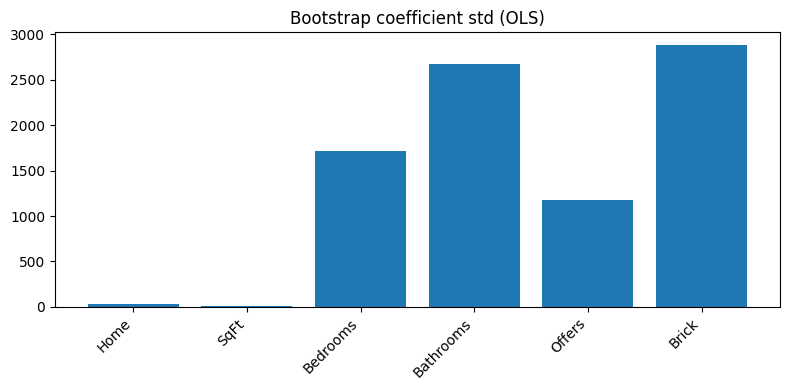

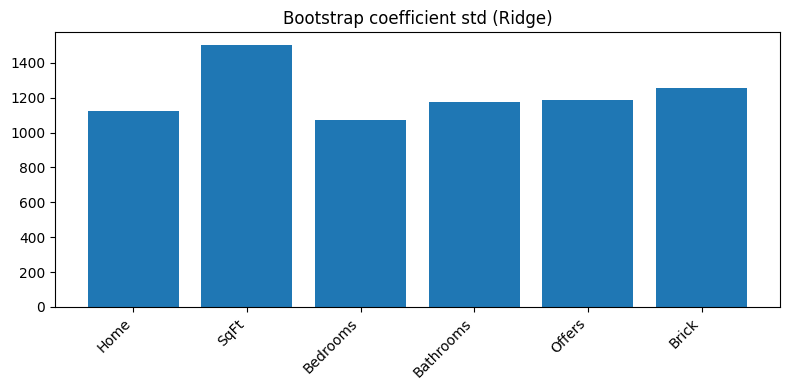

In [13]:
plt.figure(figsize=(8, 4))
plt.bar(range(len(num_cols)), ols_std.loc[num_cols].values)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.title("Bootstrap coefficient std (OLS)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(len(num_cols)), ridge_std.loc[num_cols].values)
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
plt.title("Bootstrap coefficient std (Ridge)")
plt.tight_layout()
plt.show()

### Ridge coefficient path

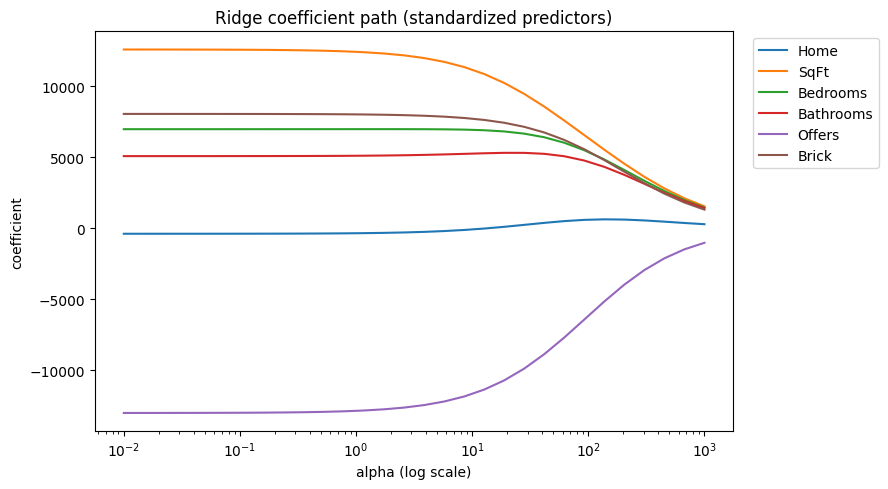

In [14]:
Xn = X[num_cols].astype(float).values
yn = y.values.astype(float)

sc = StandardScaler()
Xn_std = sc.fit_transform(Xn)

alphas = np.logspace(-2, 3, 30)
coefs = []

for a in alphas:
    m = Ridge(alpha=a)
    m.fit(Xn_std, yn)
    coefs.append(m.coef_)

coefs = np.vstack(coefs)

plt.figure(figsize=(9, 5))
for j, name in enumerate(num_cols):
    plt.plot(alphas, coefs[:, j], label=name)
plt.xscale("log")
plt.title("Ridge coefficient path (standardized predictors)")
plt.xlabel("alpha (log scale)")
plt.ylabel("coefficient")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

### PCA + Ridge pipeline

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=3))]), num_cols),
        ("cat", OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

pipe = Pipeline([("preprocess", preprocess), ("model", Ridge(alpha=10.0))])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

rmse, r2

C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(np.float64(9850.433457537012), 0.8417155468238763)

## 6) Dataset B — Diamonds: confounding and adjustment

In [16]:
diamonds_path = "../../../Datasets/Regression/diamonds.csv"
diamonds = pd.read_csv(diamonds_path)
diamonds.head()

,id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [17]:
d = diamonds.copy()

for c in ["carat", "depth", "table", "price", "x", "y", "z"]:
    d[c] = pd.to_numeric(d[c], errors="coerce")

d = d.dropna(subset=["carat", "price", "cut", "color", "clarity"])
d[["carat", "price", "cut", "color", "clarity"]].head()

,carat,price,cut,color,clarity
0,0.23,326,Ideal,E,SI2
1,0.21,326,Premium,E,SI1
2,0.23,327,Good,E,VS1
3,0.29,334,Premium,I,VS2
4,0.31,335,Good,J,SI2


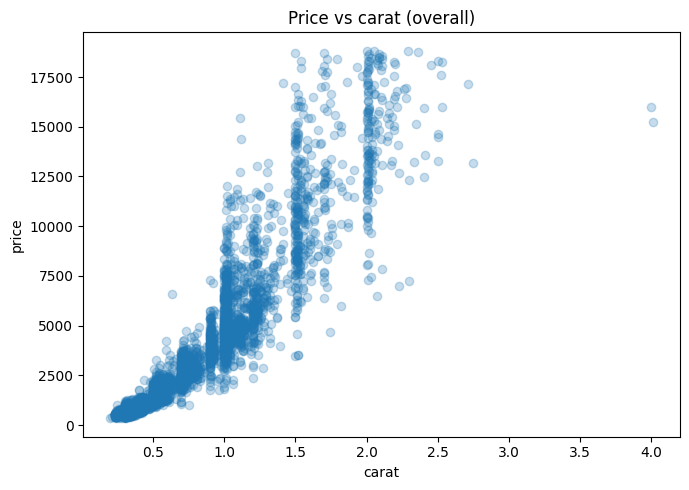

In [18]:
sample = d.sample(n=min(4000, len(d)), random_state=42)

plt.figure(figsize=(7, 5))
plt.scatter(sample["carat"], sample["price"], alpha=0.25)
plt.xlabel("carat")
plt.ylabel("price")
plt.title("Price vs carat (overall)")
plt.tight_layout()
plt.show()

In [19]:
def slope_simple(x, y):
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).astype(float)
    m = LinearRegression().fit(x, y)
    return float(m.coef_[0]), float(m.intercept_), float(m.score(x, y))

overall_slope, _, overall_r2 = slope_simple(d["carat"], d["price"])

rows = []
for cut, g in d.groupby("cut"):
    s, b, r2 = slope_simple(g["carat"], g["price"])
    rows.append((cut, len(g), s, r2))

slopes = pd.DataFrame(rows, columns=["cut", "n", "slope(price~carat)", "R2"]).sort_values("n", ascending=False)

overall_slope, overall_r2, slopes.head(10)

(7756.42561796888,
 0.8493305264354858,
          cut      n  slope(price~carat)        R2
 2      Ideal  21551         8192.391304  0.867089
 3    Premium  13791         7807.752032  0.855634
 4  Very Good  12082         7935.971965  0.858162
 1       Good   4906         7479.636303  0.850954
 0       Fair   1610         5924.495106  0.738394)

### Adjustment model: add cut/color/clarity

In [20]:
y_price = d["price"].astype(float)

XA = d[["carat"]].astype(float).values
mA = LinearRegression().fit(XA, y_price)

enc = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
Z = enc.fit_transform(d[["cut", "color", "clarity"]])

XB = np.column_stack([XA, Z])
mB = LinearRegression().fit(XB, y_price)

coef_A = float(mA.coef_[0])
coef_B = float(mB.coef_[0])
r2_A = mA.score(XA, y_price)
r2_B = mB.score(XB, y_price)

{"coef_A": coef_A, "coef_B": coef_B, "r2_A": r2_A, "r2_B": r2_B}

{'coef_A': 7756.42561796888,
 'coef_B': 8886.1288825037,
 'r2_A': 0.8493305264354858,
 'r2_B': 0.915940554017946}

### Imbalance checks (cross-tabs)

In [21]:
threshold = d["carat"].median()
d2 = d.copy()
d2["T_high_carat"] = (d2["carat"] >= threshold).astype(int)

cut_tab = pd.crosstab(d2["cut"], d2["T_high_carat"], normalize="columns")
price_by_cut = d2.groupby("cut")["price"].agg(["count", "mean", "median"]).sort_values("count", ascending=False)

cut_tab, price_by_cut.head(10)

(T_high_carat         0         1
 cut                             
 Fair          0.011040  0.046316
 Good          0.071999  0.107549
 Ideal         0.497796  0.313502
 Premium       0.216155  0.290274
 Very Good     0.203010  0.242359,
            count         mean  median
 cut                                  
 Ideal      21551  3457.541970  1810.0
 Premium    13791  4584.257704  3185.0
 Very Good  12082  3981.759891  2648.0
 Good        4906  3928.864452  3050.5
 Fair        1610  4358.757764  3282.0)

## 7) Dataset C — Diabetes: confounding in classification

In [22]:
diab_path = "../../../Datasets/Classification/diabetes.csv"
diab = pd.read_csv(diab_path)
diab.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,classification
0,6,148,72,35,0,33.6,0.627,50,Diabetic
1,1,85,66,29,0,26.6,0.351,31,Non-Diabetic
2,8,183,64,0,0,23.3,0.672,32,Diabetic
3,1,89,66,23,94,28.1,0.167,21,Non-Diabetic
4,0,137,40,35,168,43.1,2.288,33,Diabetic


In [23]:
dd = diab.copy()
dd["classification"] = dd["classification"].map({"Diabetic": 1, "Non-Diabetic": 0})
dd = dd.dropna()

X_d = dd.drop(columns=["classification"])
y_d = dd["classification"].astype(int)

X_d.shape, y_d.mean()

((768, 8), np.float64(0.3489583333333333))

In [24]:
tmp = dd.copy()
tmp["age_bin"] = pd.qcut(tmp["Age"], q=4, duplicates="drop")
tmp["bmi_bin"] = pd.qcut(tmp["BMI"], q=5, duplicates="drop")

rates = (
    tmp.groupby(["age_bin", "bmi_bin"])["classification"]
       .mean()
       .reset_index()
       .rename(columns={"classification": "diabetes_rate"})
)

rates.head()

C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_17816\161782832.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby(["age_bin", "bmi_bin"])["classification"]


,age_bin,bmi_bin,diabetes_rate
0,"(20.999, 24.0]","(-0.001, 25.9]",0.029851
1,"(20.999, 24.0]","(25.9, 30.1]",0.041667
2,"(20.999, 24.0]","(30.1, 33.7]",0.195122
3,"(20.999, 24.0]","(33.7, 37.8]",0.241379
4,"(20.999, 24.0]","(37.8, 67.1]",0.352941


C:\Users\LENOVO.PIESC\AppData\Local\Temp\ipykernel_17816\2935446279.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for age_bin, g in rates.groupby("age_bin"):


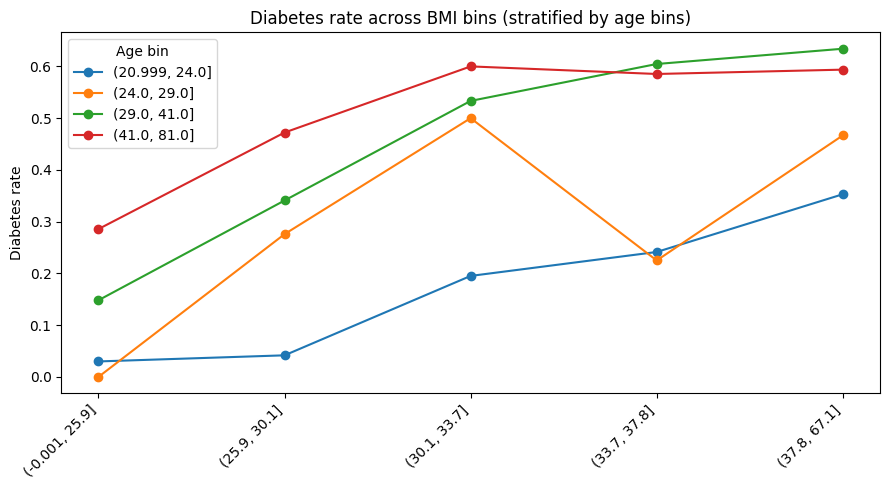

In [25]:
plt.figure(figsize=(9, 5))

for age_bin, g in rates.groupby("age_bin"):
    xs = np.arange(len(g["bmi_bin"]))
    plt.plot(xs, g["diabetes_rate"].values, marker="o", label=str(age_bin))

plt.xticks(xs, [str(b) for b in sorted(rates["bmi_bin"].unique())], rotation=45, ha="right")
plt.ylabel("Diabetes rate")
plt.title("Diabetes rate across BMI bins (stratified by age bins)")
plt.legend(title="Age bin")
plt.tight_layout()
plt.show()

### Naive vs adjusted logistic regression (AUC)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_d, y_d, test_size=0.25, random_state=42, stratify=y_d)

def fit_logit_and_auc(cols):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=500, solver="lbfgs", C=1.0))
    ])
    pipe.fit(X_train[cols], y_train)
    proba = pipe.predict_proba(X_test[cols])[:, 1]
    auc = roc_auc_score(y_test, proba)
    coef = pd.Series(pipe.named_steps["clf"].coef_[0], index=cols)
    return auc, coef

auc_bmi, coef_bmi = fit_logit_and_auc(["BMI"])
auc_adj, coef_adj = fit_logit_and_auc(["BMI", "Age", "Glucose"])

auc_bmi, auc_adj, coef_bmi, coef_adj

(np.float64(0.6885373134328359),
 np.float64(0.8081194029850746),
 BMI    0.743968
 dtype: float64,
 BMI        0.673318
 Age        0.329945
 Glucose    1.059400
 dtype: float64)

### Collinearity screening among predictors (VIF)

In [27]:
Xd = X_d.astype(float).values
feat = X_d.columns.tolist()
Xd_std = StandardScaler().fit_transform(Xd)
compute_vif(Xd_std, feat).head(15)

,feature,VIF
0,Age,1.588368
1,SkinThickness,1.507432
2,Pregnancies,1.430872
3,Insulin,1.427536
4,Glucose,1.298961
5,BMI,1.297450
6,BloodPressure,1.181863
7,DiabetesPedigreeFunction,1.067090


### Residualization diagnostic

In [28]:
# Residualization: remove age-related variation from BMI, then assess patterns
tmp = dd[["BMI", "Age", "classification"]].dropna().copy()
X_age = sm.add_constant(tmp["Age"].astype(float))
m = sm.OLS(tmp["BMI"].astype(float), X_age).fit()
tmp["BMI_resid"] = m.resid

# Compare logistic regression on BMI vs BMI_resid
X_train, X_test, y_train, y_test = train_test_split(tmp[["BMI", "BMI_resid", "Age"]], tmp["classification"].astype(int),
                                                    test_size=0.25, random_state=42, stratify=tmp["classification"])

def auc_for(col):
    pipe = Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=500, solver="lbfgs"))])
    pipe.fit(X_train[[col]], y_train)
    p = pipe.predict_proba(X_test[[col]])[:, 1]
    return roc_auc_score(y_test, p)

{"AUC_BMI": auc_for("BMI"), "AUC_BMI_resid": auc_for("BMI_resid"), "AUC_Age": auc_for("Age")}

{'AUC_BMI': np.float64(0.6885373134328359),
 'AUC_BMI_resid': np.float64(0.6844776119402985),
 'AUC_Age': np.float64(0.7037014925373135)}

## 10) Interpretation notes (read before drawing conclusions)

### 10.1 Multicollinearity is not a data “error”
It is a *geometry* property of the feature space. Many real-world domains naturally generate correlated measurements: size measures, totals and their components, economic indicators, clinical biomarkers, etc. The EDA goal is not to “eliminate” all correlation; it is to understand where redundancy will make interpretation fragile or create numerical instability.

### 10.2 What changes when you regularize
Ridge changes the objective so that solutions in poorly identified directions are shrunk. In SVD terms, directions with small singular values are precisely the ones amplified by $(X^T X)^{-1}$ in OLS; Ridge reduces their influence. This is why Ridge often yields smoother, more stable coefficient profiles under collinearity. Lasso can be useful for sparsity, but among correlated features it may pick one arbitrarily, which you will observe as split-to-split instability.

### 10.3 Confounding is a design problem, not a metric problem
You cannot “test away” confounding with one statistic. The correct question is: *what process generated the data, and what variables were measured?* In observational data, confounding is the default. Your EDA should therefore use stratification, adjustment models, and provenance checks to avoid storytelling based on aggregated correlations.

### 10.4 Causal language requires identification
Even after adjustment, a coefficient is not automatically causal. Causal claims require an identification strategy (randomization, instruments, natural experiments, or a justified causal graph). In ML tutorial settings, you should practice disciplined language: “associated with” rather than “causes.”

### 10.5 A practical reporting template
When you present results from this lesson, include: (i) correlation screening, (ii) VIF/conditioning diagnostics, (iii) a stability check, (iv) before/after mitigation comparisons, and (v) a short note about what is and is not supported by the data.

## 11) Common pitfalls (avoid these)
- Reporting only the correlation matrix and claiming multicollinearity is “solved” if correlations are below 0.8.
- Computing VIF on raw columns, but training a model on a different engineered/encoded design matrix.
- Interpreting Lasso-selected features as uniquely important when several correlated alternatives exist.
- Treating coefficient magnitude as feature importance without standardizing predictors.
- Adding polynomial terms ($x$, $x^2$) without centering and then being surprised by huge VIF values.
- Adjusting for a collider (a variable influenced by both the exposure and outcome) and creating spurious associations.
- Adjusting for post-outcome variables (data leakage in causal clothing).
- Using the training split to decide which correlated variables to drop, without checking stability across splits.
- Assuming that higher $R^2$ after adding controls proves causality.
- Using group averages to “control for confounding” but ignoring within-group variation.
- Forgetting that one-hot encoding with all levels creates perfect multicollinearity (dummy trap).
- Mixing units/scales (e.g., dollars and square-feet) and comparing coefficients directly.
- Relying on a single diagnostic (only VIF or only condition number).
- Declaring “no confounding” because an adjusted coefficient is still significant; significance is not identification.
- Ignoring domain constraints: dropping a variable that is required for fairness/auditability.

## 12) What a strong EDA report includes
- Include both a *screening* view (correlations) and a *model-based* view (VIF on the design matrix).
- Report condition number on a standardized numeric matrix and state the standardization choice.
- If coefficients are interpreted, show stability across repeated splits or bootstrap.
- If you drop features, justify with governance rules (redundancy, availability, leakage, fairness).
- For confounding, show stratified summaries and then an adjusted model; compare key coefficients.
- Separate predictive claims (“improves AUC/RMSE”) from causal claims (“causes outcome”).
- Document what variables are available at prediction time; confounders unavailable at inference cannot be used.
- When using PCA, report explained variance and loadings to retain interpretability context.
- If using regularization, report the chosen hyperparameter and how it was selected.
- Flag proxy risks: a feature can act as a proxy for a sensitive attribute, even if that attribute is excluded.

## 13) Advanced diagnostics you can add
- Partial correlation (via precision matrix) helps reveal direct associations after accounting for other predictors.
- Variance decomposition perspectives: small eigenvalues identify directions where the design matrix is nearly redundant.
- Group-wise modeling: fit the same model within strata to see whether relationships persist.
- Residualization is a diagnostic tool: remove variation explained by a suspected confounder and re-check patterns.
- High multicollinearity can make permutation importance unstable; prefer grouped importance or conditional methods.
- In categorical confounding, imbalance tables (cross-tabs) are often more informative than correlations.
- For time-dependent features, confounding can be induced by selection; respect temporal ordering explicitly.
- Do not “control for everything”: include only variables justified by your question and feature provenance.


## 14) Exercises

1. In house-prices, compare VIF and stability after dropping **Bedrooms** vs dropping **SqFt**.
2. In diamonds, extend adjustment controls and check how the carat coefficient changes.
3. In diabetes, vary regularization strength (`C`) and observe coefficient shrinkage under collinearity.
4. Create a synthetic near-linear dependency and validate that diagnostics react as expected.
5. Write an EDA note separating predictive conclusions from causal language.
